In [563]:
import numpy as np

import matplotlib.pyplot as plt
# from qiskit_machine_learning.circuit.library import RawFeatureVector

np.random.seed(0)  # For reproducibility


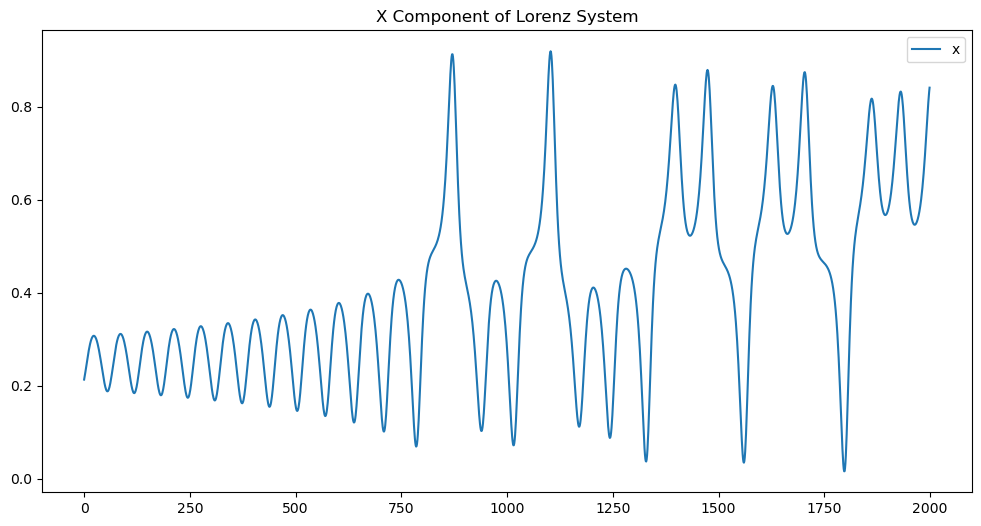

In [565]:
#number of memory and readout qubits
n_mem_qubits = 6
n_read_qubits = 6
context_length = 3
n_qubits = n_mem_qubits + n_read_qubits

#num data points
washout = 500
n_pts = 2000
test_pts = 650

#Load in lorenz data
train_data_lorenz = np.load('../data/train_data_lorenz.npy')
test_data_lorenz = np.load('../data/test_data_lorenz.npy')
#Combining data
train_data_lorenz = np.concatenate((train_data_lorenz, test_data_lorenz), axis=0)

# Remove washout
train_data = train_data_lorenz[washout:washout+n_pts]

# Use only the first component of the Lorenz system for the input signal
train_input_signal = train_data[:, 0]

#Plot each component of the Lorenz system
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(train_data[:, 0], label='x')
plt.title('X Component of Lorenz System')
#plt.plot(train_data[:, 1], label='y')
#plt.plot(train_data[:, 2], label='z')
plt.legend()
plt.show()

In [566]:
train_input_signal.shape

(2000,)

In [567]:
test_data.shape

(650, 3)

In [568]:
#random weights on the input data
#expectation = np.load('./exp_values_60000_shots_14_qubits_rep3_2024-10-15 13:08:01.913400_876.npy')
expectation = np.load('./expectations_2025-01-19 10:45:19.667516_12_ibm_marrakesh_shots_60000_seed_123123_pts_500_2000_500.npy')

In [569]:
#The code in this block will convert the output probs into expectation values, which can reduce dimensionality of the features. This may be very important as we add more qubits
#import QRNN as qrnn
#expectation = qrnn.probs_to_expectation(expectation, n_read_qubits)

In [570]:
#This line below will convert the probability distributions into expectation values

#expectation = probs_to_expectation(expectation, n_read_qubits)

# #Get condition number of expectation matrix
# print(np.linalg.cond(expectation))
# print(expectation.shape)

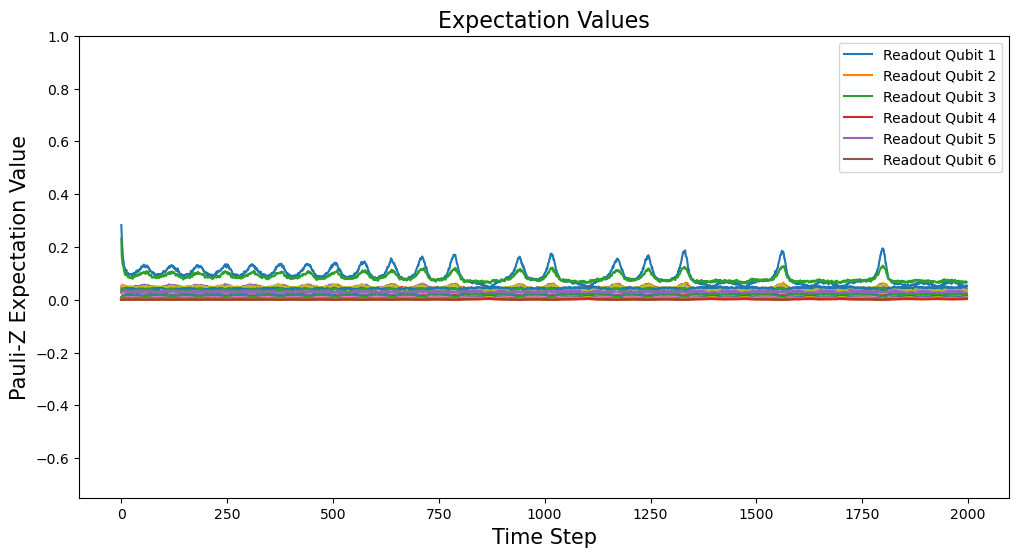

In [571]:
#Plot the expectation values
plt.figure(figsize=(12, 6))
plt.plot(expectation)
#Take the fft of the expectation values

#plt.ylim(-.75, 1)
#plt.title('Expectation Values',fontsize=16)
plt.title('Probability Distribution over Time', fontsize=16)
plt.ylabel('Probability', fontsize=15)
#plt.ylabel('Pauli-Z Expectation Value', fontsize=15)
plt.xlabel('Time Step', fontsize=15)
#plt.legend([f'Readout Qubit {i+1}' for i in range(n_read_qubits)])
#plt.savefig('QPU_probs_values.pdf')


In [572]:
# from matplotlib.animation import FuncAnimation
# # Animation function to update the bar chart for each time step
# def update_histogram(frame, features, bar_container, bit_labels):
#     histogram = features[frame]
    
#     # Update the heights of the bars
#     for rect, h in zip(bar_container, histogram):
#         rect.set_height(h)

#     plt.title(f'Histogram for Time Step {frame}')
#     return bar_container

# # Setup the figure and axis for plotting
# fig, ax = plt.subplots()
# num_outcomes = expectation.shape[1]
# bit_labels = [format(i, f'0{int(np.log2(num_outcomes))}b') for i in range(num_outcomes)]

# # Initialize the bar chart with the first time step
# bars = ax.bar(bit_labels, expectation[0])

# # Labeling and rotation
# plt.xlabel('Qubit States (bitstrings)')
# plt.ylabel('Probability')
# plt.xticks(rotation=45)

# # Create the animation
# anim = FuncAnimation(
#     fig, update_histogram, frames=len(expectation), fargs=(expectation, bars, bit_labels), blit=False, repeat=False,interval=120
# )


# # Show the animation
# anim.save('QRC_anim.mp4', writer='ffmpeg')

Train RMSE: 0.0707


/Users/erikconnerty/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.003e+00, tolerance: 2.108e-03
  model = cd_fast.enet_coordinate_descent(
/Users/erikconnerty/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.908e+00, tolerance: 2.507e-03
  model = cd_fast.enet_coordinate_descent(


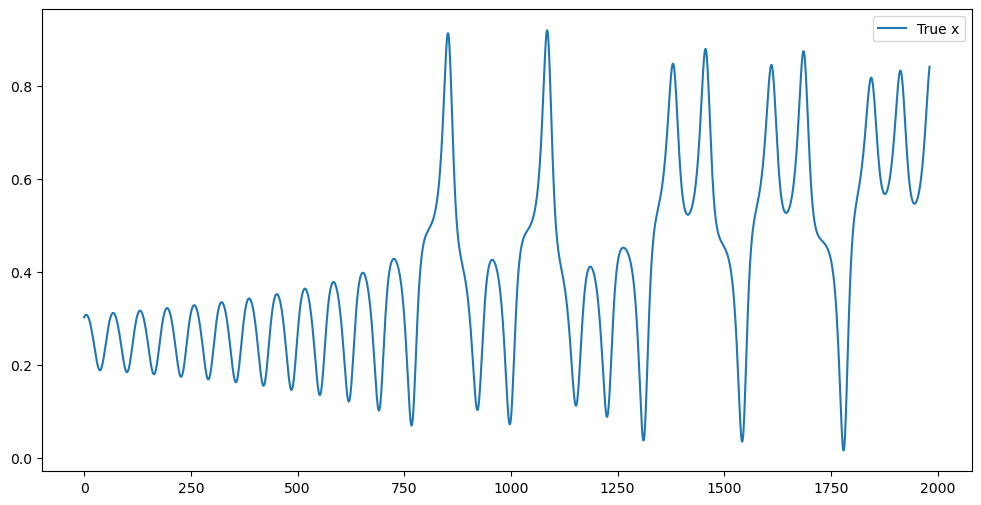

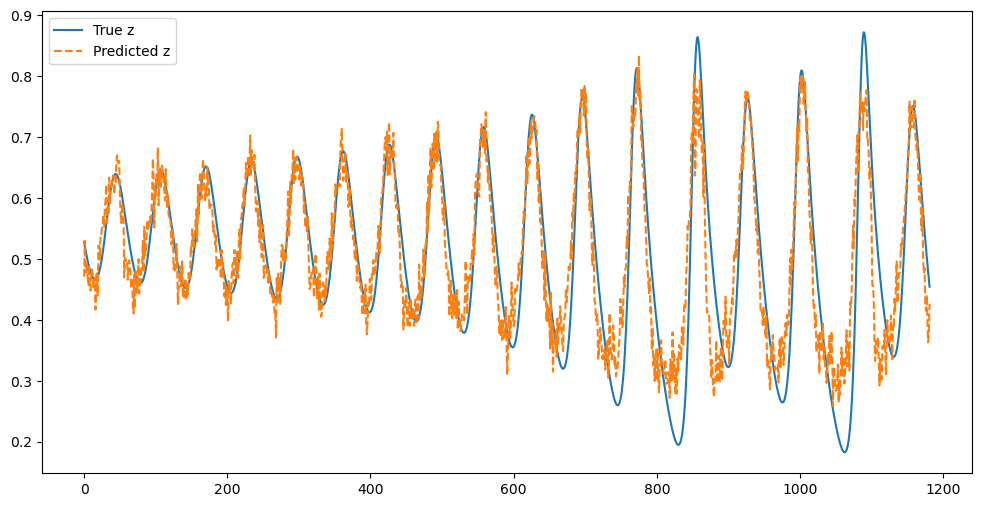

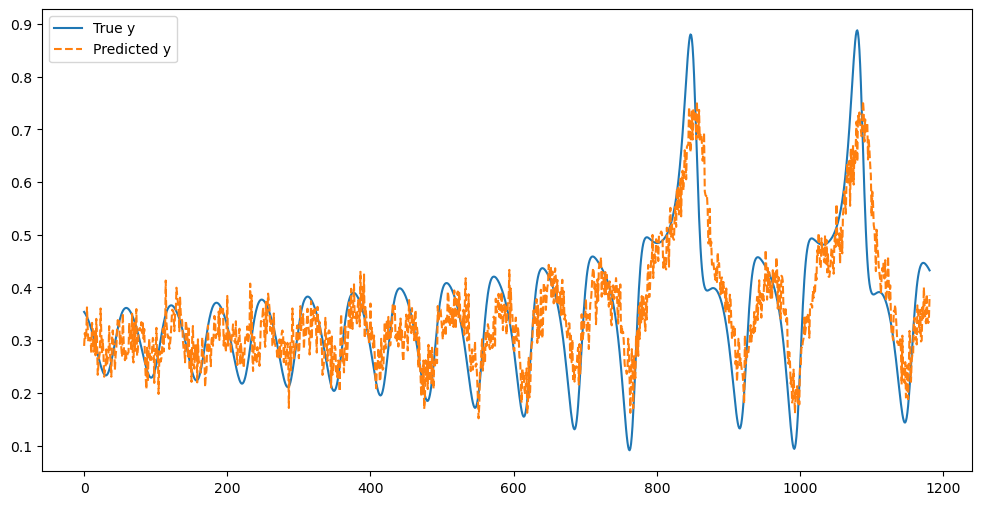

In [ ]:
from sklearn.linear_model import LinearRegression,Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error,root_mean_squared_error
from scipy import stats

washout_length = 15
train_offset = (1+context_length-1)
test_offset = 800 #How many points should come after the training data
# Prepare training and test sets
X_train = expectation[washout_length:-(1+test_offset)]

y_train = train_data[washout_length+train_offset:-(test_offset), 1:]  # Predict the second and third components

# Train a ridge regression model
#Tunine the elastic net parameters is extremely important for getting good results, especially when more qubits are used
ridge_regressor = ElasticNet(alpha=3e-7, l1_ratio=0.8)#Ridge(alpha=1)#
ridge_regressor.fit(X_train, y_train)

# Predict and evaluate the model
y_train_pred = ridge_regressor.predict(X_train)
#y_test_pred = ridge_regressor.predict(test_outputs[:-1])

#Check RMSE
train_rmse = root_mean_squared_error(y_train, y_train_pred)
#test_rmse = root_mean_squared_error(test_data[washout_length+1:, 1:], y_test_pred)
print(f'Train RMSE: {train_rmse:.4f}')
#print(f'Test RMSE: {test_rmse:.4f}')

#Plot the predicted and true second and third components of the Lorenz system
plt.figure(figsize=(12, 6))
plt.plot(train_data[washout_length+train_offset:, 0], label='True x')
plt.legend()
plt.show()
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(y_train[:, 1], label='True z')
plt.plot(y_train_pred[:,1], label='Predicted z',linestyle='dashed')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(y_train[:, 0], label='True y')
plt.plot(y_train_pred[:,0], label='Predicted y',linestyle='dashed')
plt.legend()
plt.show()



In [574]:

#expectation2 = np.load('./test_exp_values_60000_shots_14_qubits_rep3_876.npy')
expectation2 = expectation
#np.load('./expectations_2025-01-17 10:43:25.822085_12_ibm_marrakesh_shots_23000_seed_11011_pts_500_2000_500.npy')

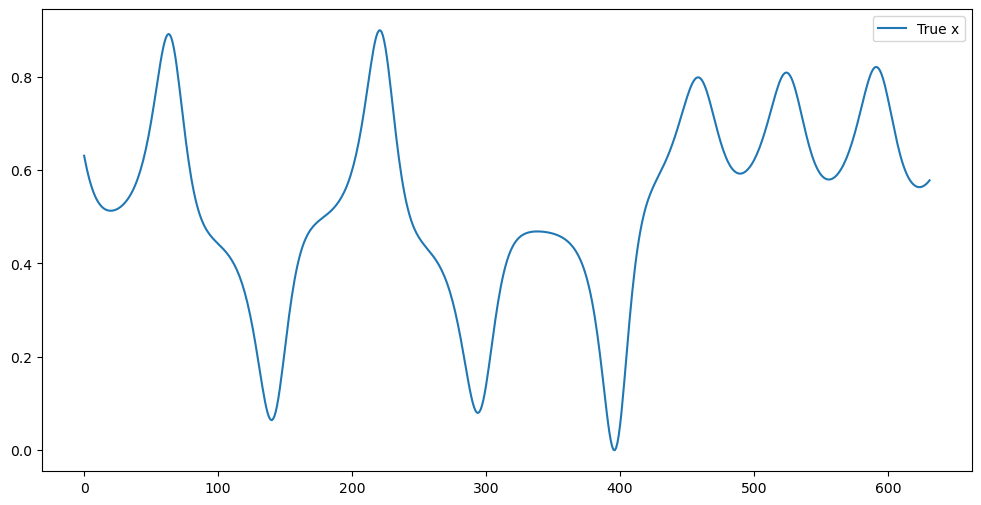

In [575]:
plt.figure(figsize=(12, 6))
plt.plot(test_data[washout_length+train_offset:, 0], label='True x')

plt.legend()
plt.show()

Test RMSE y: 0.0900
Test RMSE z: 0.0945
Test RMSE: 0.0922


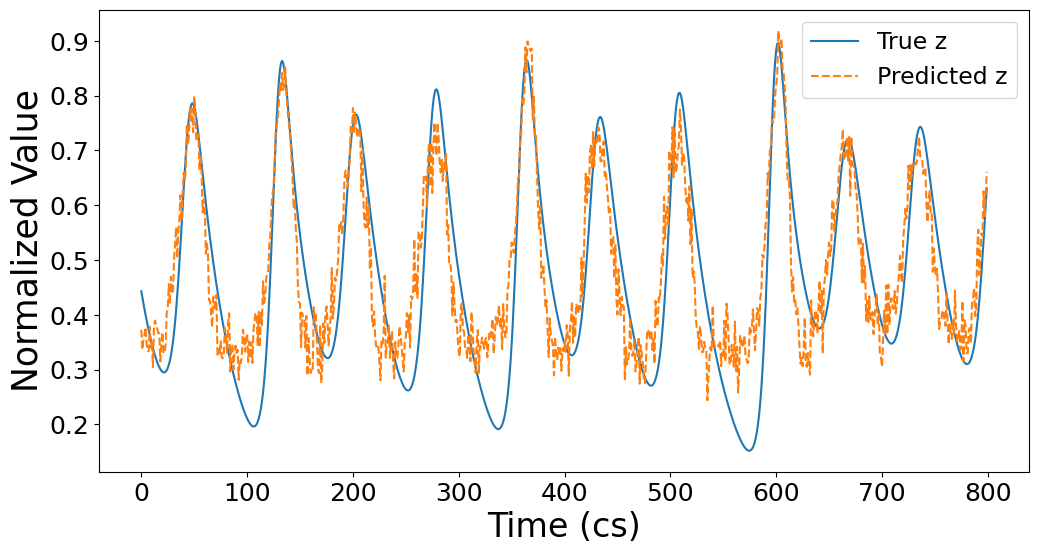

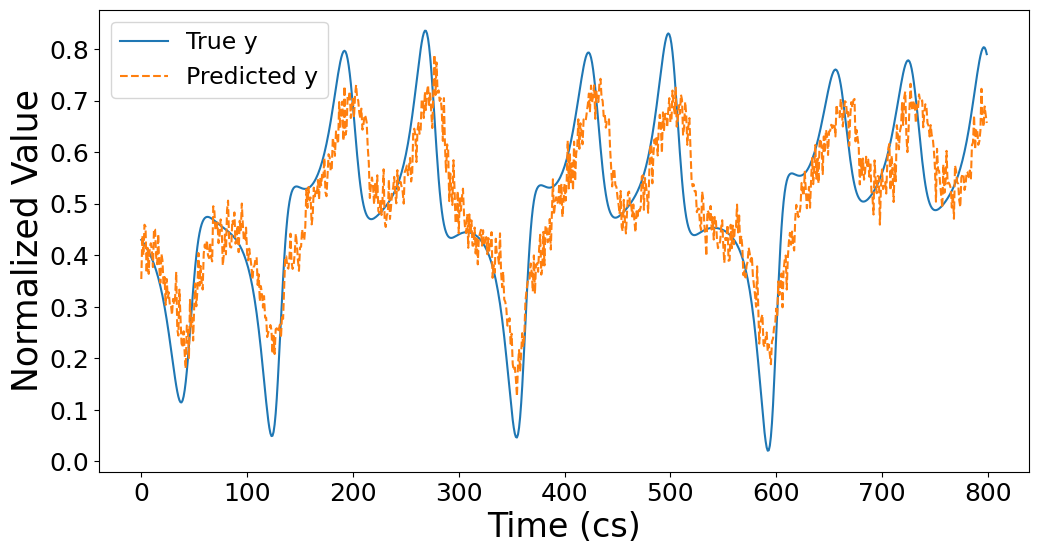

In [576]:

train_offset = (1+context_length-1)
test_offset = y_train.shape[0]
# Prepare training and test sets
X_train = expectation2[washout_length+test_offset:-1]

y_test = train_data[train_offset+washout_length+test_offset:, 1:]  # Predict the second and third components

# Use existing model for test data
y_test_pred = ridge_regressor.predict(X_train)
#y_test_pred = ridge_regressor.predict(test_outputs[:-1])

#Check RMSE
test_rmse = root_mean_squared_error(y_test[:,0], y_test_pred[:,0])
print(f'Test RMSE y: {test_rmse:.4f}')
#test_rmse = mean_squared_error(test_data[washout_length+1:, 1:], y_test_pred, squared=False)
test_rmse = root_mean_squared_error(y_test[:,1], y_test_pred[:,1])
print(f'Test RMSE z: {test_rmse:.4f}')
#test_rmse = mean_squared_error(test_data[washout_length+1:, 1:], y_test_pred, squared=False)

test_rmse = root_mean_squared_error(y_test, y_test_pred)
print(f'Test RMSE: {test_rmse:.4f}')

#Plot the predicted and true second and third components of the Lorenz system
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(y_test[:, 1], label='True z')
plt.plot(y_test_pred[:,1], label='Predicted z',linestyle='dashed')
plt.ylabel('Normalized Value',fontsize=25)
plt.xlabel('Time (cs)',fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=17)
#plt.savefig('QRC_QPU_pred_vs_true_z_16.pdf')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(y_test[:, 0], label='True y')
plt.plot(y_test_pred[:,0], label='Predicted y',linestyle='dashed')
plt.ylabel('Normalized Value',fontsize=25)
plt.xlabel('Time (cs)',fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=17)
#plt.savefig('QRC_QPU_pred_vs_true_y_16.pdf')
plt.show()


In [577]:
y_test.shape

(800, 2)

In [578]:
#Plot the MSE over time for the test data
# mse = []
# for i in range(500,len(y_test)):
#     mse.append(root_mean_squared_error(y_test[:i], y_test_pred[:i]))
# plt.figure(figsize=(12, 6))
# plt.plot(mse)
# plt.title('MSE over time for test data')
# plt.xlabel('Time')
# plt.ylabel('MSE')
# plt.show()